In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
import scipy.interpolate
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Python/python_from_R/Holocene/sampled_models/plotting_files/')
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Deglaciation/modules/')
from keyname import keyname as kn
import config
from plott import plott
import scipy.interpolate
# from mpl_toolkits.basemap import Basemap
matplotlib.use('agg')
from Cross_section import Cross_section
from Proxy_graph_masked import Proxy_graph
import Config
# from Map_plot import Map_plot
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
from IPython import embed
import os
import ast
from matplotlib import gridspec
import itertools
import xarray as xr
import json

%matplotlib inline

In [2]:
# Set Formatting variables
alpha = 0.5
point_color_dp = (0,0,1,alpha)#'blue'
point_color_shw = (1,0,0,alpha)#'red'
line_color_dp = 'cyan'
line_color_shw = 'magenta'
lw = 4
edgewidth=0.5
size = 40
fontsize = 20

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']


In [3]:
####3 reading data function

def read_data(folder):

    # Import simulation details (summary) as dataframe
    summary = pd.read_csv(folder + '_summary.txt', delimiter = ' ')

    # Import simulation outputs
    fh = Dataset(folder + 'output.nc')
    proxy_simulations = fh.variables['var1_1'][:] 

    # Import samples (proxy data)
    samples = pd.read_csv( folder + '_samples.txt', delimiter = ' ')

    # Drop all unnecessary rows in summary
    summary = summary.drop(['type', 'Row.names', 'reps', 'model', 'dataset', 'filename', 'success.rate'], axis = 1)

    # Convert run.no to netcdf file index
    summary['run.no'] = summary['run.no'] - 1
    samples['run.no'] = samples['run.no'] - 1
    
    return(proxy_simulations, samples, summary)

In [4]:
# Define a function for reading and including cores that are in the Oliver compilation but not in the Peterson data set

def Oliver_cores(minn, maxx):
    
    # Obtain the relevant data
    folder_location = '/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/'
    file_mat = ['GeoB4403_2.txt',
             'GeoB1028_5.txt',
             'GeoB2109_1.txt',
             'GeoB3801_6.txt',
             'V22_38.txt',
             'V28_56.txt',
             'V27_20.txt',
             'RC12_339.txt',
             'V32_128.txt',
             'GIK16772_1.txt',
             'MD96_2080.txt',
             'MD06_3018.txt',
             'NEAP18K.txt',
             'KNR140_37JPC.txt']

    # Specify which basin each core pertains to
    location = ['Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Indian,','Pacific,','Atlantic,','Atlantic,','Pacific,','Atlantic,','Atlantic,']

    # Create an empty list to add the results to
    oliver_data = []

    # Loop over all the cores, read in the data and add to the list
    i = 0
    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                oliver_data.append(location[i] + line)
        i += 1

    # Transform list into a dataframe
    df_oliver = pd.DataFrame([sub.split(",") for sub in oliver_data])

    # Rename the columns
    df_oliver.columns = ['Location','Core','Lat','Lon','Dep','Core depth','age','Species','pl1','pl2','d18O benthic','d13C']

    # get only the cores that are relevant
    df_oliver = df_oliver[['Core','Location','Lat','Lon','Dep','d13C','age']]

    # strip off any white spaces from the d13C results
    df_oliver['d13C'] = [i.rstrip() for i in df_oliver['d13C']]

    # get the data that falls within this period period
    df_oliver = df_oliver[df_oliver['age'].astype(float) > float(minn)]
    df_oliver = df_oliver[df_oliver['age'].astype(float) < float(maxx)]

    ################################# other data                                                                                                                                                                                                                                  

    # Obtain the relevant data
    file_mat = ['CH69_K09.txt',
    'MD03_2664.txt',
    'MD95_2042.txt',
    'U1308.txt',
    'ODP1063.txt']
    
    # Specify all the auxiliary information about the cores
    locations = ['CH69_K09\tAtlantic\t41.75\t-47.35\t4100\t',
              'MD03_2664\tAtlantic\t57.439000\t-48.605800\t3442.0\t',
              'MD95_2042\tAtlantic\t37.799833\t-10.166500\t3146.0\t',
              'U1308\tAtlantic\t49.877760\t-24.238110\t3871.0\t',
              'ODP1063\tAtlantic\t33.683333\t-57.616667\t4584\t']

    # Create an empty list to add the results to
    other_data = []
    i = 0

    # Loop over all the files and append the results to the list
    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                other_data.append(locations[i]+line)
        i += 1

    # Create a dataframe of the other core data
    df_other = pd.DataFrame([sub.split("\t") for sub in other_data])

    # rename the columns
    df_other.columns = ['Core','Location','Lat','Lon','Dep','Core Depth','age','d13C']

    # get only the columns that we care about
    df_other = df_other[['Core','Location','Lat','Lon','Dep','d13C','age']]

    # strip any white spaces off of the d13C variable
    df_other['d13C'] = [i.rstrip() for i in df_other['d13C']]

    # Extract the results which fall within this period period
    df_other = df_other[df_other['age'].astype(float) > float(minn)]
    df_other = df_other[df_other['age'].astype(float) < float(maxx)]

    # Combine the Oliver and other dataframes together
    df_all_results = pd.concat([df_oliver, df_other])

    # Drop any d13C results which are empty
    df_all_results = df_all_results[df_all_results['d13C'] != '']

    # Make sure all variables are in the right data type
    df_all_results['d13C'] = df_all_results['d13C'].astype(float)
    df_all_results['Lat'] = df_all_results['Lat'].astype(float)
    df_all_results['Lon'] = df_all_results['Lon'].astype(float)
    df_all_results['Dep'] = df_all_results['Dep'].astype(float)
    
    return(df_all_results)    
    

In [5]:

def pl_cores(minn, maxx):

    # Set the names of the pandas columns
    names = ['Core', 'Location', 'Lat', 'Lon', 'Dep']

    # Read in the data (three files; two for different basins and an addition file)
    indopac = pd.read_table("../Moving_water_mass/Data/Core_files/indopac_core_data_LS16.txt", delimiter = ',', names = names)
    atl = pd.read_table("../Moving_water_mass/Data/Core_files/atl_core_data_LS16.txt", delimiter = ',', names = names)
    add = pd.read_table("../Moving_water_mass/Data/Core_files/Additional_core_locations.txt", delimiter = ',', usecols = [0, 1, 2, 3, 4], names = names)

    # Join all into a single dataframe
    df_loc = indopac.append(atl)
    df_loc = df_loc.append(add)
    df_loc = df_loc.reset_index(drop = True)

    # Determine the names of the files as they would be saved from their core names
    df_loc['d18O names'] = df_loc['Core'] + '_ageLS16.txt'
    df_loc['d13C names'] = df_loc['Core'] + '_d13C.txt'


    # Create an empty dictionary for all the results, and row counter
    i = 0
    results_dict = {}

    # Loop over the dataset and interpolate each core age model to d13C data    
    while i < df_loc.count()[0]:

        # Try getting the age model (d18O) and d13C data for a core. If you can't, move on to next core
        try:
            df_d18O = pd.read_table('../Moving_water_mass/Data/Core_files/' + df_loc.loc[i]['d18O names'], delim_whitespace = True, names = ['depth', 'age'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue
        try:
            df_d13C = pd.read_table('../Moving_water_mass/Data/Core_files/' + df_loc.loc[i]['d13C names'], delim_whitespace = True, names = ['depth', 'd13C'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue

        # Preprocess data to remove NaNs
        df_d18O = df_d18O.dropna(subset = ['age']) 
        df_d13C = df_d13C.dropna(subset = ['d13C'])

        # Drop the meaningless index
        df_d18O = df_d18O.reset_index(drop = True)
        df_d13C = df_d13C.reset_index(drop = True)

        # from the age model files, create an interpolation function
        interp = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = True)
        try:
            df_d13C['age'] = interp(df_d13C['depth'])
        except:
            try:
                interp2 = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = False)
                df_d13C['age'] = interp2(df_d13C['depth'])
            except:
                i += 1
                continue    
    
        # Drop ages where it's nan
        df_d13C = df_d13C.dropna(subset = ['age'])
        
        # Drop the index. It's meaningless
        df_d13C = df_d13C.reset_index(drop = True)

        # get only the cores that are within this period period
        df_d13C = df_d13C[df_d13C['age'] > minn]
        df_d13C = df_d13C[df_d13C['age'] < maxx]

        # If the dataframe is not empty
        if len(df_d13C) > 0:
            
            # Drop irrelevant columns from the location dataframe
            df_single_core_loc = df_loc.drop(['d18O names', 'd13C names'], axis = 1)
            
            # replicate a single core location data for the same number of columns as there are d13C rows
            df_single_core_loc = df_single_core_loc.loc[
                df_single_core_loc.index.repeat(len(df_d13C))].loc[[i]]

            # Drop depth (not relevant)
            df_d13C = df_d13C.drop(['depth'], axis = 1)

            # Join the d13C data to the single core location data
            df_single_core_loc = \
                df_single_core_loc.reset_index(drop = True).join(df_d13C.reset_index(drop = True))
            
            # Add the results of this core to the results dictionary
            results_dict.update({
                df_single_core_loc.Core[0] : df_single_core_loc.drop(['Core'], axis = 1)
            })

        i += 1
        
    # Join all the dataframes in the results dictionary into a single dataframe
    df_results = pd.concat(results_dict).reset_index()
    
    # relabel core column
    df_results = df_results.rename(columns = {'level_0' : 'Core'})
    df_results = df_results.drop(['level_1'], axis = 1)

    return(df_results)
    

In [6]:

def slicing_data(period_min,period_max,location_filter):

    # run the function to collect all of the relevant Peterson and Lisiecki cores
    df_pl = pl_cores(period_min,period_max)

    # run the function to collect all of the relevant Oliver cores
    df_oliver = Oliver_cores(period_min,period_max)
    
    # Combine both sets of cores together
    df_results = df_pl.append(df_oliver)

    # Drop the index (it has no meaning)
    df = df_results.reset_index(drop = True)
    
    # Make sure that all depths are positive (some provide their data with negative cores)
    df['Dep'] = abs(df['Dep'])

    # Get only the cores for this given ocean
    df = df[df['Location'] == location_filter]
    
    # drop the index, since it has no meaning
    df = df.reset_index(drop = True)
    
    # make sure that the core ages are given as floats (not strings)
    df['age'] = df.age.astype(float)

    # Slice the data to make a lower and upper period frame for the moving average
    lower = np.arange(period_min, period_max, config.slice_moving_amount)
    upper = np.arange(period_min+config.slice_width, period_max+config.slice_width, config.slice_moving_amount)

    # Creat an empty dictionary 
    proxy_compilation = {}

    # Loop through each of the period windows
    for low, up in zip(lower, upper):
        
        # Get only the points that fall within this particular subslice
        df_slice = df[(df['age'] >= low) & (df['age'] < up)]
        
        # group the slice based on cores
        grouped_slice = df_slice.groupby(['Core'])
        
        # get the mean and count per core in this slice
        df_slice_averaged = \
            grouped_slice.mean().join(grouped_slice.count()[['Lat']].rename(columns={'Lat':'count'}))
        
        # Rename the age column age_mean, since it is the average of the ages in that slice
        df_slice_averaged.rename(columns={'age':'age_mean'},inplace=True)
        
        # get the average age of the slice, and add averaged dataframe to a dict under that index
        proxy_compilation.update({
            (low+up)/2 : df_slice_averaged
        })
        
    # Transform dictionary of dataframes into a single dataframe
    proxy_compilation = pd.concat(proxy_compilation,axis=0)
    
    # Reset the index, and name the age index column
    proxy_compilation.reset_index(drop=False,inplace=True)
    proxy_compilation.rename(columns={'level_0':'age'},inplace=True)
    
    return(df, proxy_compilation)

In [7]:
def slice_interpolation(proxy_compilation):
    # interpolating across the entire dataset

    # Add time bounds to the samples table
    samples_with_time_period = proxy_compilation

    unique_cores = np.unique(samples_with_time_period['Core'])
    years_list = np.unique(samples_with_time_period.age)

    samples_with_time_period = samples_with_time_period.reset_index(drop=True)

    interpolated_proxies = {}

    for unique_core in unique_cores:

        # get a single proxy
        df_temp = samples_with_time_period[samples_with_time_period['Core'] == unique_core]

        try:
            # interpolate the dataset
            interp = scipy.interpolate.interp1d(df_temp['age'],
                                                df_temp['d13C'],
                                                bounds_error = False)
            single_proxy_interpolated = pd.DataFrame({'age' : years_list, 'd13C' : interp(years_list)})        
            location_repeated = pd.concat([df_temp.reset_index(0).loc[0,['Lat', 'Lon', 'Dep','count']]] * len(single_proxy_interpolated), axis=1).T
            single_proxy_interpolated = pd.concat([location_repeated.reset_index(drop=True), single_proxy_interpolated.reset_index(drop=True)],axis=1)    

            interpolated_proxies.update({
                unique_core : single_proxy_interpolated
            })        

        except ValueError:
            interpolated_proxies.update({
                unique_core : df_temp.drop('Core',axis=1)
            })

    interpolated_samples = pd.concat(interpolated_proxies).reset_index(drop=False).rename(columns={'level_0':'Core'}).drop(['level_1'],axis=1)
    interpolated_samples_backup = interpolated_samples.copy()

    # Drop count because this count doesn't make sense
    interpolated_samples = interpolated_samples.drop('count',axis=1)

    # Merge the original dataframe to get counts back (nan for interpolated samples)
    interpolated_samples = pd.merge(interpolated_samples, proxy_compilation[['age','Core','count']],
                                    how='outer', left_on=['age','Core'], right_on=['age','Core'])

    # Drop all nan d13C values (interpolation tried but out of range)
    interpolated_samples = interpolated_samples[np.isfinite(interpolated_samples['d13C'])]
    
    return(interpolated_samples)

In [8]:
def make_latex_table(proxy_compilation,latex_name):
#     # Save list of cores to latex table to include in paper
    latex_table = proxy_compilation.drop(['d13C','count','age'],axis=1)
#     latex_table['Reference'] = '-'
#     latex_table = latex_table.drop_duplicates()

#     # Rename columns
#     latex_table = latex_table.rename(columns={'Lat':'Latitude','Lon' : 'Longitude', 'Dep' : 'Depth (m)'})
#     latex_table['Latitude'] = [str(round(x, 2)) for x in latex_table.Latitude]
#     latex_table['Longitude'] = [str(round(x, 2)) for x in latex_table.Longitude]
#     latex_table.sort_values(by='Core',inplace=True)

#     # Convert to string of latex markdown
#     latex_string = latex_table.to_latex(index=False,longtable=True)

#     # Reformat some parts of the latex table
#     latex_string = latex_string.replace('\\toprule','')
#     latex_string = latex_string.replace('\\midrule','')
#     latex_string = latex_string.replace('\\bottomrule','')

#     # Write to a file
#     file1 = open(latex_name,"w") 
#     file1.write(latex_string) 
#     file1.close() #to change file access modes 
  

In [9]:

def Atlantic_regions(proxy_compilation):
    # Get volume weight average with period slices
    proxy_compilation['weights'] = np.nan
    proxy_compilation['regions'] = np.nan    

    # NEA
    proxy_compilation.loc[((proxy_compilation['Lon'] < 20) | (proxy_compilation['Lon'] > (-33))) & (proxy_compilation['Lat'] > 0.1),
                            'weights'] = 4.3
    proxy_compilation.loc[((proxy_compilation['Lon'] < 20) | (proxy_compilation['Lon'] > (-33))) & (proxy_compilation['Lat'] > 0.1),
                            'regions'] = 'NEA'
    

    # NWA
    proxy_compilation.loc[(proxy_compilation['Lon'] < (-33)) & (proxy_compilation['Lon'] > (-180)) & (proxy_compilation['Lat'] > 0.1),
                             'weights'] = 4.9
    proxy_compilation.loc[(proxy_compilation['Lon'] < (-33)) & (proxy_compilation['Lon'] > (-180)) & (proxy_compilation['Lat'] > 0.1),
                             'regions'] = 'NWA'

    # SEA
    proxy_compilation.loc[((proxy_compilation['Lon'] < 30) | (proxy_compilation['Lon'] > (-14.6))) & (proxy_compilation['Lat'] < 0) & (proxy_compilation['Lat'] > -55),
                             'weights'] = 3.5
    proxy_compilation.loc[((proxy_compilation['Lon'] < 30) | (proxy_compilation['Lon'] > (-14.6))) & (proxy_compilation['Lat'] < 0) & (proxy_compilation['Lat'] > -55),
                             'regions'] = 'SEA'
    
    # SA
    proxy_compilation.loc[((proxy_compilation['Lon'] < 30) | (proxy_compilation['Lon'] > (-22))) & (proxy_compilation['Lat'] < -40) & (proxy_compilation['Lat'] > -55),
                            'weights'] = 0.7
    proxy_compilation.loc[((proxy_compilation['Lon'] < 30) | (proxy_compilation['Lon'] > (-22))) & (proxy_compilation['Lat'] < -40) & (proxy_compilation['Lat'] > -55),
                            'regions'] = 'SA'    

    # SWA
    proxy_compilation.loc[(proxy_compilation['Lon'] > (-60)) & (proxy_compilation['Lon'] < (-14.6)) & (proxy_compilation['Lat'] < 0) & (proxy_compilation['Lat'] > -55),
                            'weights'] = 5.0
    proxy_compilation.loc[(proxy_compilation['Lon'] > (-60)) & (proxy_compilation['Lon'] < (-14.6)) & (proxy_compilation['Lat'] < 0) & (proxy_compilation['Lat'] > -55),
                            'regions'] = 'SWA'    
    
    return(proxy_compilation)
    
def Pacific_regions(proxy_compilation):
    # Get volume weight average with period slices
    proxy_compilation['weights'] = np.nan
    proxy_compilation['regions'] = np.nan      

    # North
    proxy_compilation.loc[(proxy_compilation['Lat'] > 0) ,'weights'] = 21.2
    proxy_compilation.loc[(proxy_compilation['Lat'] > 0) ,'regions'] = 'NP'    

    # South
    proxy_compilation.loc[(proxy_compilation['Lat'] < 0) ,'weights'] = 23.9
    proxy_compilation.loc[(proxy_compilation['Lat'] < 0) ,'regions'] = 'SP'
    
    return(proxy_compilation)

def Indian_regions(proxy_compilation):
    # Get volume weight average with period slices # Use a single region for the Indian Ocean
    proxy_compilation['weights'] = 1
    proxy_compilation['regions'] = 'I'
    
    return(proxy_compilation)


In [10]:
def averaging_by_region(proxy_compilation):
    
    # group the cores based on the age and the region (indicated by weights)
    grouped_by_age_region = proxy_compilation.groupby(['age', 'regions'])
    
    averaged_by_age_region = {}
    stdev_by_age_region = {}
    measurement_count = {}
    core_count = {}
    CI_by_age_region = {}
    
    for key, group in grouped_by_age_region:
        
        # find group means
        averaged_by_age_region.update({
            key: np.mean(group)
        })
        # find total number of cores
        core_count.update({
            key: len(group['count'].dropna())
        }) 
        # find total measurement count
        measurement_count.update({
            key: np.nansum(group['count'])
        })
        # find the standard deviation across the slices and cores
        stdev_by_age_region.update({
            key: np.std(group['d13C'])
        })
        # express variation as a confidence interval
        CI_by_age_region.update({
            key: 1.96 * np.std(group['d13C'])/(np.sqrt(len(group['count'].dropna()))) #CI of 95%, 1.96 is zscore
        })        
        
    # Convert dictionaries to dataframes
    averaged_by_age_region = pd.concat(averaged_by_age_region,axis=1).T.reset_index(drop=False).rename({'level_1':'regions'},axis=1).drop('level_0',axis=1)
    measurement_count = pd.DataFrame.from_dict(measurement_count,orient='index')
    core_count = pd.DataFrame.from_dict(core_count,orient='index')
    stdev_by_age_region = pd.DataFrame.from_dict(stdev_by_age_region,orient='index')
    CI_by_age_region = pd.DataFrame.from_dict(CI_by_age_region,orient='index')    
    
    # Add columns of number of cores and number of measurements to the dataframe
    averaged_by_age_region['measurement_count'] = list(measurement_count[0])
    averaged_by_age_region['core_count'] = list(core_count[0])  
    averaged_by_age_region['slice_stdev'] = list(stdev_by_age_region[0])
    averaged_by_age_region['CI'] = list(CI_by_age_region[0])
    
    # Now there is one values for each region (weight) and each year combination
    # Group by years and use weights to find the average d13C for that period period
    grouped_by_age = averaged_by_age_region.drop('regions',axis=1).groupby('age')

    # Drop the core details, since we've averaged by regions in this df, and we don't need them now
    averaged_by_age_region = averaged_by_age_region.drop(['count','Lat','Lon','Dep'],axis=1)    
    
    # Make empty dictionaries to store results
    averaged_by_age = {}
    stdev_by_age = {}

    # find group means by looping over age-region groups
    for key, group in grouped_by_age:

        # Find the volume weighted average of the age-region group
        averaged_by_age.update({
            np.mean(group['age']) : np.sum(group['d13C'] * group['weights'])/np.sum(group['weights'])
        })
        
        # Find the normal average
        avg = np.mean(group.d13C)
        
        # Use this average to find the standard deviation of the age-region group
        stdev_by_age.update({
            np.mean(group['age']) : np.average((group.d13C-avg)**2,weights=group.weights)
        }) 

    # Convert results dicts to dataframes
    averaged_by_age = pd.DataFrame.from_dict(averaged_by_age,orient='index').reset_index(drop=False).rename(columns={'index' : 'age', 0 : 'd13C'})
    stdev_by_age = pd.DataFrame.from_dict(stdev_by_age,orient='index').reset_index(drop=False).rename(columns={'index' : 'age', 0 : 'stdev'})

    # Join the two results (avg and stdev) to a single df
    averaged_by_age = pd.merge(left=averaged_by_age,right=stdev_by_age)
    
    # Order the results by age
    averaged_by_age = averaged_by_age.sort_values('age')
    
    return(averaged_by_age,averaged_by_age_region)


In [11]:
def save_results(results_dict,period,basin,proxy_compilation,averaged_by_age_region,averaged_by_age,df_all_data):

    # Save raw d13C results (all the data)
    results_dict.update({
        kn(period=period[1],basin=basin,vartype='df_d13C_unsliced'): \
        df_all_data.to_dict()
    })

    # Save raw d13C results (all the data)
    results_dict.update({
        kn(period=period[1],basin=basin,vartype='df_d13C_raw'): \
        proxy_compilation.to_dict()
    })
        
    # Save the d13C data which has been grouped into age and region
    results_dict.update({
        kn(period=period[1],basin=basin,vartype='d13C_avg_age_region'): \
        averaged_by_age_region.to_dict()
    })
        
    # Save the d13C data that is just a time series, and the volume weightings have been considered
    results_dict.update({
        kn(period=period[1],basin=basin,vartype='d13C_avg_age'): \
        averaged_by_age.to_dict()
    })       

    return(results_dict)

In [12]:
# Create an empty dictionary to store the results in
results_dict = {}

# List the different variables that can be combined
basin = ['Atlantic','Pacific','Indian']
config.period_list=[[(150,0),'LD']]

# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[config.period_list,basin]))).rename(
    columns={0:'period',1:'basin'})

# Loop over all the combinations
for period,basin in zip(
    combinations['period'],
    combinations['basin']
    ):
    
    # Define the region function to used based on what basin it is
    if basin=='Atlantic':
        region_func = Atlantic_regions
    elif basin=='Pacific':
        region_func = Pacific_regions
    elif basin=='Indian':
        region_func = Indian_regions
    
    # Run function for slicing the data, getting all samples and averaged by period slice
    df_all_data, proxy_compilation = slicing_data(np.min(period[0]),np.max(period[0]),basin)
    
    # Interpolate samples
    interpolated_samples = slice_interpolation(proxy_compilation)
    
    # get region weights
    interpolated_samples = region_func(interpolated_samples)
    
    # Get regional average and ocean basin averages
    averaged_by_age, averaged_by_age_region = averaging_by_region(interpolated_samples)    
    
    # Save the results
    save_results(results_dict,period,basin,interpolated_samples,averaged_by_age_region,averaged_by_age,df_all_data)
    

/srv/ccrc/data06/z5145948/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/srv/ccrc/data06/z5145948/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


In [13]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Deglaciation/modules/')
from keyname import keyname as kn
import config
import itertools
import json

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fontsize = 18


In [14]:

# Load the period definitions
df_periods = pd.DataFrame(config.period_list,columns=['range','name'])

In [15]:
# Get the relevant hashkey
hashkey_d13C_unsliced = kn(basin='Atlantic',period='LD',vartype='df_d13C_unsliced')

# From the results dict, create dataframe for the relevant results using the hashkey
df_d13C_unsliced = pd.DataFrame.from_dict(results_dict[hashkey_d13C_unsliced])


In [16]:
df_PS = df_d13C_unsliced[df_d13C_unsliced.Core=='PS2498']

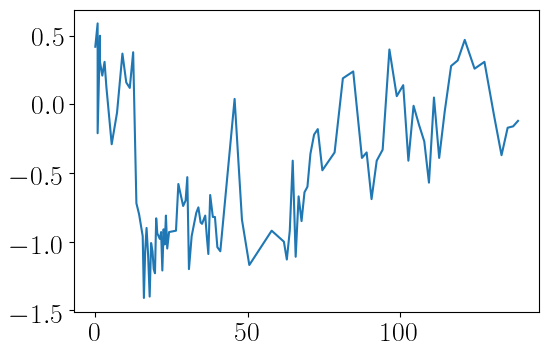

In [17]:
plt.plot(df_PS.age,df_PS.d13C)

plt.show()